In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import json

import nibabel
import nilearn
import numpy as np
import sklearn
import pandas as pd

from nilearn import plotting

import rtcloud

In [2]:
# Prepare test samples
test_subject = 2
data_dir = "data"

haxby = nilearn.datasets.fetch_haxby(data_dir="datasets", subjects=[test_subject])
labels_test = pd.read_csv(haxby.session_target[0], sep=" ")
y_test_all = labels_test["labels"]
condition_mask_test = y_test_all.isin(["face", "house"])

In [3]:
fmri_img_test = nilearn.image.index_img(haxby.func[0], condition_mask_test)
fmri_data_test = fmri_img_test.get_data()
y_test = y_test_all[condition_mask_test]
for sample in range(fmri_data_test.shape[-1]):
    sample_data = fmri_data_test[..., sample][..., np.newaxis]
    sample_img = nilearn.image.new_img_like(fmri_img_test, sample_data)
    nibabel.save(sample_img, "{}/subject-{}-sample-{:03}.nii.gz".format(data_dir, test_subject, sample))

In [14]:
conf = {
    'test': 1
}
mask_img = nibabel.load(haxby.mask)
conf['experiment_data'] = {
    "models": sklearn.externals.joblib.load("models.pkl"),
    "mask_data": mask_img.get_data().astype(bool),
    "mask_affine": mask_img.affine,
}

# client = rtcloud.Client(server_ip='ec2-34-237-207-176.compute-1.amazonaws.com', conf=conf)
client = rtcloud.Client(server_ip='localhost', conf=conf)

client.start()

In [15]:
client.queue(input_dir=data_dir, tr=500, loop=True)

Process Process-8:
Traceback (most recent call last):
  File "/Users/dsuo/rtcloud/venv/lib/python3.6/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
KeyboardInterrupt
  File "/Users/dsuo/rtcloud/venv/lib/python3.6/site-packages/multiprocess/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/dsuo/rtcloud/rtcloud/client.py", line 119, in queue_helper
    time.sleep(float(tr / 1000))


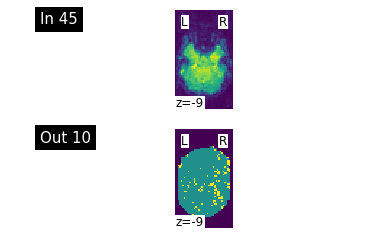

Process Process-9:
Traceback (most recent call last):
  File "/Users/dsuo/rtcloud/venv/lib/python3.6/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/dsuo/rtcloud/venv/lib/python3.6/site-packages/multiprocess/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/dsuo/rtcloud/rtcloud/client.py", line 166, in watch_helper
    channel.start_consuming()
  File "/Users/dsuo/rtcloud/venv/lib/python3.6/site-packages/pika/adapters/blocking_connection.py", line 1756, in start_consuming
    self.connection.process_data_events(time_limit=None)
  File "/Users/dsuo/rtcloud/venv/lib/python3.6/site-packages/pika/adapters/blocking_connection.py", line 707, in process_data_events
    self._flush_output(common_terminator)
KeyboardInterrupt
  File "/Users/dsuo/rtcloud/venv/lib/python3.6/site-packages/pika/adapters/blocking_connection.py", line 455, in _flush_output
    self._impl.ioloop.poll()
  File "/Users/dsuo/rtcloud/ven

KeyboardInterrupt: 

In [ ]:
client.watch()
client.display()